In [95]:
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from keras.regularizers import l1, l2
from tensorflow.keras import initializers
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import KFold
import keras_tuner
import keras
from keras import layers
import itertools
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
import keras.backend as K
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from math import ceil

seed = 7
tf.random.set_seed(seed)
tf.config.run_functions_eagerly(False)

In [96]:
def plot_curves(curve_1, label_1, curve_2=None, label_2=None):
    if curve_1 is not None: 
        plt.plot(curve_1, label = label_1)
    if curve_2 is not None: 
        plt.plot(curve_2, label = label_2)   
    plt.legend()
    plt.show()

In [97]:
scaler = None

def load_monks(path, encode):
    
    train = pd.read_csv(f"{path}.train", header=None, sep=" ")
    test = pd.read_csv(f"{path}.test", header=None, sep=" ")
    
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)
    train.drop(8, axis=1, inplace=True)
    test.drop(8, axis=1, inplace=True)
    
    y_train = train.iloc[:, 0].to_numpy().astype(np.float64)
    x_train = train.iloc[:, 1:].to_numpy().astype(np.float64)
    y_test = test.iloc[:, 0].to_numpy().astype(np.float64)
    x_test = test.iloc[:, 1:].to_numpy().astype(np.float64)
    
        
    if encode:
        
        encoder = OneHotEncoder()
        
        encoder.fit(x_train)
        x_train = encoder.transform(x_train).toarray()
        
        encoder.fit(x_test)
        x_test = encoder.transform(x_test).toarray()
        
        
    
    print(f"Loaded {path} dataset")
    
    return x_train, y_train, x_test, y_test
    

def load_cup(scale):
    global scaler
    
    scaler = StandardScaler()
    
    train = pd.read_csv("../data/ML-CUP22-TR.csv", header=None, sep=",")
    test = pd.read_csv("../data/ML-CUP22-TS.csv", header=None, sep=",")
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)

    y_train = train.iloc[:, 9:].to_numpy().astype(np.float64)
    x_train = train.iloc[:, :9].to_numpy().astype(np.float64)
    x_test = test.to_numpy().astype(np.float64)
    
    if scale:
        # scaler = MinMaxScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.fit_transform(x_test)
        y_train = scaler.fit_transform(y_train)
        
    return x_train, y_train, x_test, None
    
    
    
def load_dataset(dataset, encode=True):
    assert dataset in ["monks1", "monks2", "monks3", "cup"]
    
    if dataset == "monks1":
        return load_monks("./../data/monks-1", encode)
    elif dataset == "monks2":
        return load_monks("./../data/monks-2", encode)
    elif dataset == "monks3":
        return load_monks("./../data/monks-3", encode)
    else:
        return load_cup(encode)

In [98]:
def median_index(array):
    n = len(array)
    med_idx = np.argsort(array)[ceil((n-1)/2)]
    # med_val = array[med_idx]
    return med_idx #, med_val

def mee(y_true_t, y_pred_t):
    '''y_true = y_true_t.numpy()
    y_pred = y_pred_t.numpy()
    y_true = scaler.inverse_transform(y_true)
    y_pred = scaler.inverse_transform(y_pred)
    return np.sqrt(np.square(y_true - y_pred).sum(axis=1)).mean()'''
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(y_true_t - y_pred_t), axis=1)))

def merge_dicts(dicts):
    merged = {}
    for d in dicts:
        merged = {**merged, **d}
    return merged


def get_attributes_num(dataset):
    return 1 if len(dataset.shape) == 1 else dataset.shape[1]


def get_params_configurations(params):
    
    keys = list(params.keys())
    keys.remove("layers")
    keys.remove("task")
    keys.remove("initialization")
    keys.remove("early_stopping")
    keys.remove("regularization")
    keys.remove("nesterov")
    keys.remove("trials_train")
    keys.remove("trials_test")
    keys.remove("learning_rate_decay")
    sorted_keys = sorted(keys)
    arguments = []
    for key in sorted_keys:
        arguments.append(params[key])
    
    arguments = tuple(arguments)
    all_params = list(itertools.product(*arguments))
        
    configurations = []
    
    for conf in all_params:
        
        dict_conf = {}
        
        for i in range(len(sorted_keys)):
            dict_conf[sorted_keys[i]] = conf[i]
        dict_conf["initialization"] = params["initialization"]
        dict_conf["early_stopping"] = params["early_stopping"]
        dict_conf["task"] = params["task"]
        dict_conf["trials_train"] = params["trials_train"]
        dict_conf["trials_test"] = params["trials_test"]
        dict_conf["nesterov"] = params["nesterov"]
        dict_conf["learning_rate_decay"] = params["learning_rate_decay"]
        
        # add regularization parameters
        for reg in params["regularization"]:
            method = reg["type"]
            
            if method == None:
                reg_dict_conf = dict_conf.copy()
                reg_dict_conf["regularization"] = {
                    "method": None
                }
                configurations.append(reg_dict_conf)
                continue
            
            for val in reg["value"]:
                reg_dict_conf = dict_conf.copy()
                reg_dict_conf["regularization"] = {
                    "method": method,
                    "value": val
                }
        
                configurations.append(reg_dict_conf)
            
        
    return configurations


def get_callbacks(config):
    
    lr_decay = config["learning_rate_decay"]
    early_stopping = config["early_stopping"]
    
    callbacks = []
    
    if early_stopping != None:
        early_stop = EarlyStopping(
            monitor=early_stopping["monitor"], 
            patience=early_stopping["patience"], 
            min_delta=early_stopping["delta"], 
        )
        callbacks.append(early_stop)

    if lr_decay != None:
        decay_epochs = lr_decay["epochs"]
        lr_final = lr_decay["lr_final"]
        linear_scheduler = get_linear_scheduler(decay_epochs, lr_final)
        scheduler = LearningRateScheduler(linear_scheduler)
        callbacks.append(scheduler)
        
    return callbacks if callbacks != [] else None
        


def get_layers_configurations(params, configurations):
    layers = params["layers"]
    layers_params_confs = []
    
    for n_layer in range(len(layers)):
        layers_params_confs.append([]) 
    
    for i in range(len(layers)):
        layer = layers[i]
        activations = layer["activations"]
        units = layer["units"]
        layer_confs = list(itertools.product(activations, units))
        for conf in layer_confs:
            conf_dict = {
                f"activations_{i+1}": conf[0],
                f"units_{i+1}": conf[1]
            }
            layers_params_confs[i].append(conf_dict)
        
    layers_confs = []
    for i in range(len(layers_params_confs)):
        confs = layers_params_confs[:i+1]
        confs = tuple(confs)
        confs = list(itertools.product(*confs))
        for conf in confs:
            layers_confs.append(merge_dicts(conf))
                
    return layers_confs



def get_configurations(params):
    
    configurations = get_params_configurations(params)
    layers_confs = get_layers_configurations(params, configurations)
    configurations = list(itertools.product(configurations, layers_confs))
    configurations_merged = []
    
    for conf in configurations:
        configurations_merged.append(merge_dicts(conf))
        
    
    return configurations_merged

            

def get_linear_scheduler(epochs, lr_final):
    
    def linear_scheduler(epoch, lr):
        if (epoch < epochs):
            alpha = epoch/epochs
            return (1-alpha)*lr + alpha*lr_final
        else:
            return lr_final
        
    return linear_scheduler
    

def get_model(config, input_size, output_size):
    
    lr = config["learning_rate"]
    momentum = config["momentum"]
    init_method = config["initialization"]["type"]
    task = config["task"]
    nesterov = config["nesterov"]
    
    reg_method = config["regularization"]["method"]
    
    if reg_method == "l1":
        reg_value = config["regularization"]["value"]
        reg = l1(reg_value)
    elif reg_method == "l2":
        reg_value = config["regularization"]["value"]
        reg = l2(reg_value)
    else:
        reg = None
    
    
    init = None
    if init_method == "uniform":
        min_val = config["initialization"]["min"]
        max_val = config["initialization"]["max"]
        init = initializers.RandomUniform(minval=min_val, maxval=max_val, seed=None)
    if init_method == "normal":
        mean = config["initialization"]["mean"]
        std = config["initialization"]["std"]
        init = initializers.RandomNormal(mean=mean, stddev=std, seed=None)
        
    
    optimizer = SGD(learning_rate=lr, momentum=momentum, nesterov=nesterov)
    
    n_layers = 0
    for key in config.keys():
        if key.startswith("units_"):
            n_layers += 1

    model = Sequential()
    
    activation = config["activations_1"]
    n_units = config["units_1"]
    model.add(Dense(n_units, input_dim=input_size, activation=activation,
                    kernel_regularizer=reg, bias_regularizer=reg,
                    kernel_initializer = init, bias_initializer = init))
    
    for l in range(2,n_layers+1):
        activation = config[f"activations_{l}"]
        n_units = config[f"units_{l}"]
        
        model.add(Dense(n_units, activation=activation,
                        kernel_regularizer=reg, bias_regularizer=reg,
                        kernel_initializer = init, bias_initializer = init))
        
        
    if task == "classification":
        model.add(Dense(output_size, activation="sigmoid",
                        kernel_regularizer=reg, bias_regularizer=reg,
                        kernel_initializer = init, bias_initializer = init))
        
        model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])
        
    elif task == "regression":
        model.add(Dense(output_size, activation="linear",
                        kernel_regularizer=reg, bias_regularizer=reg,
                        kernel_initializer = init, bias_initializer = init))
        
        model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = [mee])
        
    return model
    
    
def fit_model_k_fold(x_train, y_train, config, n_folds):
    
    task = config["task"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mee"
        val_metric = "val_mee"
    
    trials = config["trials_train"]
    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    
    callbacks = get_callbacks(config)

    
    kf = KFold(n_splits = n_folds, shuffle=True)

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    fold = 1
    for train_index, val_index in kf.split(x_train, y_train):
        
        print(f"\nExecuting fold {fold}/{n_folds}")
        
        input_size = get_attributes_num(x_train)
        output_size = get_attributes_num(y_train)
        
                
        x_train_fold = x_train[train_index]
        y_train_fold = y_train[train_index]

        x_val_fold = x_train[val_index]
        y_val_fold = y_train[val_index]

        
        trials_val_loss = []
        trials_train_loss = []
        trials_val_acc = []
        trials_train_acc = []
        
        with tqdm(total=trials) as pbar:
            for trial in range(trials):
                model = get_model(config, input_size, output_size)
                history = model.fit(x_train_fold, y_train_fold, epochs=max_epochs,
                                    validation_data=(x_val_fold, y_val_fold),
                                    callbacks=callbacks, verbose = 0)

                trial_train_loss = history.history["loss"]
                trial_val_loss = history.history["val_loss"]         
                trial_train_acc = history.history[train_metric]
                trial_val_acc = history.history[val_metric]

                trials_val_loss.append(trial_val_loss[-1])
                trials_train_loss.append(trial_train_loss[-1])
                trials_val_acc.append(trial_val_acc[-1])
                trials_train_acc.append(trial_train_acc[-1])

                pbar.update(1)
            
        # get the median metrics among the trials
        med_idx = median_index(trials_val_loss)
        med_val_loss = trials_val_loss[med_idx]
        med_train_loss = trials_train_loss[med_idx]
        med_val_acc = trials_val_acc[med_idx]
        med_train_acc = trials_train_acc[med_idx]
        std_val_loss = np.std(trials_val_loss)
        std_train_loss = np.std(trials_train_loss)
        std_val_acc = np.std(trials_val_acc)
        std_train_acc = np.std(trials_train_acc)

        print(f"Fold {fold}/{n_folds} median val_loss: {med_val_loss}, std val_loss {std_val_loss}")
        print(f"Fold {fold}/{n_folds} median train_loss: {med_train_loss}, std train_loss {std_train_loss}")
        print(f"Fold {fold}/{n_folds} median {val_metric}: {med_val_acc}, std {val_metric} {std_val_acc}")
        print(f"Fold {fold}/{n_folds} median train_{train_metric}: {med_train_acc}, train_{train_metric} {std_train_acc}")
            
        train_losses.append(med_train_loss)
        val_losses.append(med_val_loss)
        val_accs.append(med_val_acc)
        train_accs.append(med_train_acc)
        
        fold += 1
        
    mean_train_loss = np.mean(train_losses)
    mean_val_loss = np.mean(val_losses)
    mean_train_acc = np.mean(train_accs)
    mean_val_acc = np.mean(val_accs)
    std_train_loss = np.std(train_losses)
    std_val_loss = np.std(val_losses)
    std_train_acc = np.std(train_accs)
    std_val_acc = np.std(val_accs)
    
    print(f"\nMean val_loss: {mean_val_loss}, std val_loss: {std_val_loss}")
    print(f"Mean train_loss: {mean_train_loss}, std train_loss: {std_train_loss}")
    print(f"Mean {val_metric}: {mean_val_acc}, std {val_metric}: {std_val_acc}")
    print(f"Mean train_{train_metric}: {mean_val_acc}, std train_{train_metric}: {std_train_acc}")
    
    return mean_val_loss




def fit_model_hold_out(x_train, y_train, config, val_split):
    
    task = config["task"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mee"
        val_metric = "val_mee"
        
    trials = config["trials_train"]
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
    
    
    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]

    
    callbacks = get_callbacks(config)
    
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_split, shuffle=True)

    
    trials_val_loss = []
    trials_train_loss = []
    trials_val_acc = []
    trials_train_acc = []
        
    with tqdm(total=trials) as pbar:
        for trial in range(trials):            
            model = get_model(config, input_size, output_size)
            history = model.fit(x_train, y_train, epochs=max_epochs, batch_size=batch_size,
                                verbose=0, validation_data=(x_val, y_val), callbacks=callbacks)
            

            trial_train_loss = history.history["loss"]
            trial_val_loss = history.history["val_loss"]         
            trial_train_acc = history.history[train_metric]
            trial_val_acc = history.history[val_metric]
            
            trials_val_loss.append(trial_val_loss[-1])
            trials_train_loss.append(trial_train_loss[-1])
            trials_val_acc.append(trial_val_acc[-1])
            trials_train_acc.append(trial_train_acc[-1])
            
            pbar.update(1)
    
    # get the median metrics among the trials
    med_idx = median_index(trials_val_loss)
    med_val_loss = trials_val_loss[med_idx]
    med_train_loss = trials_train_loss[med_idx]
    med_val_acc = trials_val_acc[med_idx]
    med_train_acc = trials_train_acc[med_idx]
    std_val_loss = np.std(trials_val_loss)
    std_train_loss = np.std(trials_train_loss)
    std_val_acc = np.std(trials_val_acc)
    std_train_acc = np.std(trials_train_acc)

    print(f"Median val_loss: {med_val_loss}, std val_loss {std_val_loss}")
    print(f"Median train_loss: {med_train_loss}, std train_loss {std_train_loss}")
    print(f"Median {val_metric}: {med_val_acc}, std {val_metric} {std_val_acc}")
    print(f"Median train_{train_metric}: {med_train_acc}, train_{train_metric} {std_train_acc}")
    
    return med_val_loss
    
    
def fit_model_test(x_train, y_train, x_test, y_test, config):
    
    task = config["task"]
    trails = config["trials_test"]
    
    if task == "classification":
        train_metric = "accuracy"
        test_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mee"
        test_metric = "val_mee"

    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    trials = config["trials_test"]
    
    if config["early_stopping"]["monitor"] == "val_loss":
        config["early_stopping"]["monitor"] = "loss"
        
    callbacks = get_callbacks(config)
    
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
    
    
    trials_test_loss = []
    trials_train_loss = []
    trials_test_acc = []
    trials_train_acc = []
    
    trials_history_test_loss = []
    trials_history_train_loss = []
    trials_history_test_acc = []
    trials_history_train_acc = []   
    
    models = []
    
    with tqdm(total=trials) as pbar:
        for trial in range(trials):
            model = get_model(config, input_size, output_size)
            history = model.fit(x_train, y_train, epochs=max_epochs, validation_data=(x_test, y_test),
                                batch_size=batch_size, verbose=0, callbacks=callbacks)

            models.append(model)

            trial_train_loss = history.history["loss"]
            trial_test_loss = history.history["val_loss"]         
            trial_train_acc = history.history[train_metric]
            trial_test_acc = history.history[test_metric]

            trials_test_loss.append(trial_test_loss[-1])
            trials_train_loss.append(trial_train_loss[-1])
            trials_test_acc.append(trial_test_acc[-1])
            trials_train_acc.append(trial_train_acc[-1])

            trials_history_test_loss.append(trial_test_loss)
            trials_history_train_loss.append(trial_train_loss)
            trials_history_test_acc.append(trial_test_acc)
            trials_history_train_acc.append(trial_train_acc)

            print(f"Trial {trial+1}/{trials} test_loss: {trial_test_loss[-1]}")
            print(f"Trial {trial+1}/{trials} train_loss: {trial_train_loss[-1]}")
            print(f"Trial {trial+1}/{trials} {test_metric}: {trial_test_acc[-1]}")
            print(f"Trial {trial+1}/{trials} {train_metric}: {trial_train_acc[-1]}")

            pbar.update(1)
        
    med_idx = median_index(trials_test_loss)
    med_test_loss = trials_test_loss[med_idx]
    med_train_loss = trials_train_loss[med_idx]
    med_test_acc = trials_test_acc[med_idx]
    med_train_acc = trials_train_acc[med_idx]
    std_test_loss = np.std(trials_test_loss)
    std_train_loss = np.std(trials_train_loss)
    std_test_acc = np.std(trials_test_acc)
    std_train_acc = np.std(trials_train_acc)
    
    print(f"\nMedian test_loss: {med_test_loss}, std test_loss {std_test_loss}")
    print(f"Median train_loss: {med_train_loss}, std train_loss {std_train_loss}")
    print(f"Median test_{train_metric}: {med_test_acc}, std test_{train_metric} {std_test_acc}")
    print(f"Median train_{train_metric}: {med_train_acc}, std train_{train_metric} {std_train_acc}")
        
    
        
    train_acc = trials_history_train_acc[med_idx]
    test_acc = trials_history_test_acc[med_idx]
    plot_curves(train_acc, f"Training {train_metric}", test_acc, f"Test {train_metric}")
    
    train_loss = trials_history_train_loss[med_idx]
    test_loss = trials_history_test_loss[med_idx]
    plot_curves(train_loss, "Train loss", test_loss, "Test loss")
    
    med_model = models[med_idx]
    
    return med_model


def fit_model_no_test(x_train, y_train, config):
    task = config["task"]
    trails = config["trials_test"]
    
    if task == "classification":
        train_metric = "accuracy"
    elif task == "regression":
        train_metric = "mee"

    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    early_stopping = config["early_stopping"]
    trials = config["trials_test"]
    
    if config["early_stopping"]["monitor"] == "val_loss":
        config["early_stopping"]["monitor"] = "loss"
        
    callbacks = get_callbacks(config)
    
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
    
    
    trials_train_loss = []
    trials_train_acc = []
    
    trials_history_train_loss = []
    trials_history_train_acc = []   
    
    models = []
    
    with tqdm(total=trials) as pbar:
        for trial in range(trials):
            model = get_model(config, input_size, output_size)
            history = model.fit(x_train, y_train, epochs=max_epochs,
                                batch_size=batch_size, verbose=0, callbacks=callbacks)

            models.append(model)

            trial_train_loss = history.history["loss"]
            trial_train_acc = history.history[train_metric]

            trials_train_loss.append(trial_train_loss[-1])
            trials_train_acc.append(trial_train_acc[-1])

            trials_history_train_loss.append(trial_train_loss)
            trials_history_train_acc.append(trial_train_acc)

            print(f"Trial {trial+1}/{trials} train_loss: {trial_train_loss[-1]}")
            print(f"Trial {trial+1}/{trials} train_{train_metric}: {trial_train_acc[-1]}")

            pbar.update(1)
        
    med_idx = median_index(trials_train_loss)
    med_train_loss = trials_train_loss[med_idx]
    med_train_acc = trials_train_acc[med_idx]
    std_train_loss = np.std(trials_train_loss)
    std_train_acc = np.std(trials_train_acc)
    
    print(f"\nMedian train_loss: {med_train_loss}, std train_loss {std_train_loss}")
    print(f"Median train_{train_metric}: {med_train_acc}, std train_{train_metric} {std_train_acc}")
    
        
    
        
    train_acc = trials_history_train_acc[med_idx]
    plot_curves(train_acc, f"Training {train_metric}")
    
    train_loss = trials_history_train_loss[med_idx]
    plot_curves(train_loss, f"Train loss")
    
    med_model = models[med_idx]
    
    return med_model

    
def fit_model(x_train, y_train, config, validation):
    if validation["type"] == "k-fold":
        val_loss = fit_model_k_fold(x_train, y_train, config, validation["n_folds"])
    elif validation["type"] == "hold-out":
        val_loss = fit_model_hold_out(x_train, y_train, config, validation["val_split"])
    return val_loss



def test_model(model, x_test, y_test):
    input_size = x_test.shape[1]
    result = model.evaluate(x_test, y_test)
    print(result)

    
    
def model_selection(configurations, x_train, y_train, validation):
        
    best_loss = float("inf")
    best_conf = None
    
    idx = 1
    n_confs = len(configurations)
    for config in configurations:

        print(f"Testing configuration {idx}/{n_confs}:\n{config}")
        val_loss = fit_model(x_train, y_train, config, validation)

        if val_loss < best_loss:
            best_loss = val_loss;
            best_conf = config
        idx += 1
        
        print("\n\n")

            
    print("\n\n")
    print(f"Best configuration (loss {best_loss}):\n{best_conf}")
    
    return best_conf
    

def grid_search(params, x_train, y_train, validation={"type": "hold-out", "val_split": 0.2}, x_test=None, y_test=None ):
    configurations = get_configurations(params)    
    best_conf = model_selection(configurations, x_train, y_train, validation)
    if x_test is None:
        model = fit_model_no_test(x_train, y_train, best_conf)
    else:
        model = fit_model_test(x_train, y_train, x_test, y_test, best_conf)
        
    return model

In [99]:
params = {
    "task": "classification",
    "trials_train": 5,
    "trials_test": 10,
    "initialization": {
        # "type": "uniform",
        # "min": -0.5,
        # "max": 0.5
        "type": "normal",
        "mean": 0,
        "std": 1
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.001
    },
    "max_epochs": [500],
    "learning_rate": [0.1],
    "batch_size": [None],
    "momentum": [0.9],
    "nesterov": False,
    "learning_rate_decay": None,
    "regularization": [
        {
            "type": None
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [5],
        },
    ]
}


"""params = {
    "initialization": {
        "type": "uniform",
        "min": -0.5,
        "max": 0.5
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.001
    },
    "max_epochs": 500,
    "learning_rate": [0.001, 0.01, 0.1],
    "batch_size": [None],
    "momentum": [0.1, 0.9],
    "learning_rate_decay": {
        "epochs": 50,
        "lr_final": 0.01
    },
    "regularization": [
        {
            "type": "l1",
            "value": [0.0001, 0.001]
        },
        {
            "type": "l2",
            "value": [0.0001, 0.001]
        },
        {
            "type": None
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [1,4,8],
        },
    ]
}"""

k_fold_val = {
    "type": "k-fold",
    "n_folds": 5
}

hold_out_val = {
    "type": "hold-out",
    "val_split": 0.15
}

# Monks 1

In [84]:
x_train, y_train, x_test, y_test = load_dataset("monks1", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Loaded ./../data/monks-1 dataset
(124, 17) (124,)
(432, 17) (432,)


In [85]:
model = grid_search(params, x_train, y_train, k_fold_val, x_test, y_test)
test_model(model, x_test, y_test)

Testing configuration 1/1:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'normal', 'mean': 0, 'std': 1}, 'early_stopping': {'monitor': 'val_loss', 'patience': 100, 'delta': 0.001}, 'task': 'classification', 'trials_train': 5, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 5}

Executing fold 1/5


  0%|                                                     | 0/5 [00:15<?, ?it/s]


AssertionError: 

# Monks 2

In [58]:
x_train, y_train, x_test, y_test = load_dataset("monks2", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Loaded ./../data/monks-2 dataset
(169, 17) (169,)
(432, 17) (432,)


Testing configuration 1/1:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.001}, 'task': 'classification', 'trials_train': 5, 'trials_test': 10, 'nesterov': False, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 5}

Executing fold 1/5


100%|█████████████████████████████████████████████| 5/5 [00:24<00:00,  4.87s/it]


Fold 1/5 median val_loss: 0.0028550431597977877, std val_loss 0.09154268194467038
Fold 1/5 median train_loss: 0.0018068562494590878, std train_loss 0.08500125016184774
Fold 1/5 median val_accuracy: 1.0, std val_accuracy 0.18564391417496787
Fold 1/5 median train_accuracy: 1.0, train_accuracy 0.13435003309350127

Executing fold 2/5


100%|█████████████████████████████████████████████| 5/5 [00:18<00:00,  3.76s/it]


Fold 2/5 median val_loss: 0.0020439517684280872, std val_loss 0.09552749505161438
Fold 2/5 median train_loss: 0.0016265339218080044, std train_loss 0.08276939958763005
Fold 2/5 median val_accuracy: 1.0, std val_accuracy 0.1529411792755127
Fold 2/5 median train_accuracy: 1.0, train_accuracy 0.15111110210418702

Executing fold 3/5


100%|█████████████████████████████████████████████| 5/5 [00:24<00:00,  4.99s/it]


Fold 3/5 median val_loss: 0.001805025851354003, std val_loss 0.0038166868713823106
Fold 3/5 median train_loss: 0.0019109476124867797, std train_loss 0.0003202965027607919
Fold 3/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 5/5 [00:16<00:00,  3.36s/it]


Fold 4/5 median val_loss: 0.0020092064514756203, std val_loss 0.08128904275088941
Fold 4/5 median train_loss: 0.0019526280229911208, std train_loss 0.06698707176814825
Fold 4/5 median val_accuracy: 1.0, std val_accuracy 0.1529411792755127
Fold 4/5 median train_accuracy: 1.0, train_accuracy 0.08592593669891357

Executing fold 5/5


100%|█████████████████████████████████████████████| 5/5 [00:13<00:00,  2.78s/it]


Fold 5/5 median val_loss: 0.2763579487800598, std val_loss 0.14408347606149566
Fold 5/5 median train_loss: 0.1857752799987793, std train_loss 0.09656347589992512
Fold 5/5 median val_accuracy: 0.5151515007019043, std val_accuracy 0.25898012583513186
Fold 5/5 median train_accuracy: 0.7352941036224365, train_accuracy 0.14411764716615547

Mean val_loss: 0.05701423520222306, std val_loss: 0.10967244395436329
Mean train_loss: 0.03861444916110486, std train_loss: 0.07358050157157932
Mean val_accuracy: 0.9030303001403809, std val_accuracy: 0.1939393997192383
Mean train_accuracy: 0.9030303001403809, std train_accuracy: 0.10588235855102539






Best configuration (loss 0.05701423520222306):
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.001}, 'task': 'classification', 'trials_train': 5, 'trials_test': 10, 'nesterov': False, 'regular

 10%|████▍                                       | 1/10 [00:10<01:30, 10.04s/it]

Trial 1/10 test_loss: 0.18656887114048004
Trial 1/10 train_loss: 0.10928436368703842
Trial 1/10 val_accuracy: 0.8009259104728699
Trial 1/10 accuracy: 0.8934911489486694


 20%|████████▊                                   | 2/10 [00:15<01:00,  7.62s/it]

Trial 2/10 test_loss: 0.0014164374442771077
Trial 2/10 train_loss: 0.001388993812724948
Trial 2/10 val_accuracy: 1.0
Trial 2/10 accuracy: 1.0


 30%|█████████████▏                              | 3/10 [00:20<00:42,  6.01s/it]

Trial 3/10 test_loss: 0.0012361378176137805
Trial 3/10 train_loss: 0.0010475397575646639
Trial 3/10 val_accuracy: 1.0
Trial 3/10 accuracy: 1.0


 40%|█████████████████▌                          | 4/10 [00:24<00:33,  5.58s/it]

Trial 4/10 test_loss: 0.0020635423716157675
Trial 4/10 train_loss: 0.0012934849364683032
Trial 4/10 val_accuracy: 1.0
Trial 4/10 accuracy: 1.0


 50%|██████████████████████                      | 5/10 [00:30<00:28,  5.66s/it]

Trial 5/10 test_loss: 0.002635642886161804
Trial 5/10 train_loss: 0.001820513280108571
Trial 5/10 val_accuracy: 1.0
Trial 5/10 accuracy: 1.0


 60%|██████████████████████████▍                 | 6/10 [00:35<00:21,  5.27s/it]

Trial 6/10 test_loss: 0.0010307603515684605
Trial 6/10 train_loss: 0.0009453639504499733
Trial 6/10 val_accuracy: 1.0
Trial 6/10 accuracy: 1.0


 70%|██████████████████████████████▊             | 7/10 [00:40<00:16,  5.41s/it]

Trial 7/10 test_loss: 0.0032837192993611097
Trial 7/10 train_loss: 0.0013254130026325583
Trial 7/10 val_accuracy: 1.0
Trial 7/10 accuracy: 1.0


 80%|███████████████████████████████████▏        | 8/10 [00:45<00:10,  5.18s/it]

Trial 8/10 test_loss: 0.0017669950611889362
Trial 8/10 train_loss: 0.0015559798339381814
Trial 8/10 val_accuracy: 1.0
Trial 8/10 accuracy: 1.0


 90%|███████████████████████████████████████▌    | 9/10 [00:51<00:05,  5.46s/it]

Trial 9/10 test_loss: 0.00150792277418077
Trial 9/10 train_loss: 0.0013688066974282265
Trial 9/10 val_accuracy: 1.0
Trial 9/10 accuracy: 1.0


100%|███████████████████████████████████████████| 10/10 [00:56<00:00,  5.70s/it]

Trial 10/10 test_loss: 0.0020553022623062134
Trial 10/10 train_loss: 0.0016846677754074335
Trial 10/10 val_accuracy: 1.0
Trial 10/10 accuracy: 1.0

Median test_loss: 0.0020553022623062134, std test_loss 0.055407819001586714
Median train_loss: 0.0016846677754074335, std train_loss 0.03237192023544034
Median test_accuracy: 1.0, std test_accuracy 0.05972222685813904
Median train_accuracy: 1.0, std train_accuracy 0.031952655315399175


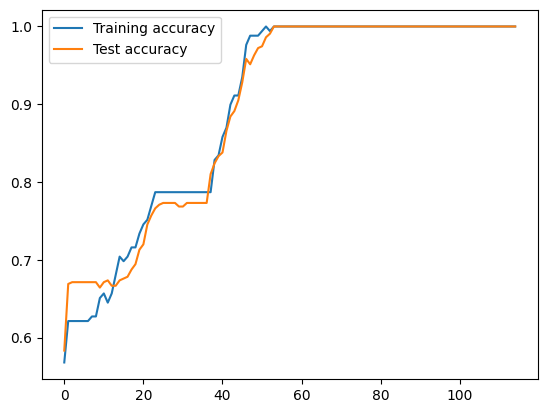

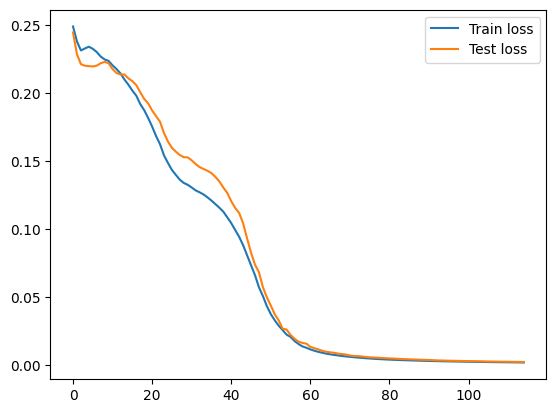

14/14 [==============================] - 0s 1ms/step - loss: 0.0021 - accuracy: 1.0000
[0.0020553022623062134, 1.0]


In [59]:
model = grid_search(params, x_train, y_train, k_fold_val, x_test, y_test)
test_model(model, x_test, y_test)

# Monks 3

In [70]:
x_train, y_train, x_test, y_test = load_dataset("monks3", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Loaded ./../data/monks-3 dataset
(122, 17) (122,)
(432, 17) (432,)


Testing configuration 1/1:
{'batch_size': None, 'learning_rate': 0.01, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.001}, 'task': 'classification', 'trials_train': 5, 'trials_test': 10, 'nesterov': False, 'regularization': {'method': 'l1', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 5}

Executing fold 1/5


100%|█████████████████████████████████████████████| 5/5 [00:21<00:00,  4.29s/it]


Fold 1/5 median val_loss: 0.10474454611539841, std val_loss 0.07102599700345792
Fold 1/5 median train_loss: 0.08483191579580307, std train_loss 0.07599718910023709
Fold 1/5 median val_accuracy: 0.9200000166893005, std val_accuracy 0.17600001096725462
Fold 1/5 median train_accuracy: 0.938144326210022, train_accuracy 0.1649484634399414

Executing fold 2/5


100%|█████████████████████████████████████████████| 5/5 [00:47<00:00,  9.54s/it]


Fold 2/5 median val_loss: 0.03862278535962105, std val_loss 0.003954712323690696
Fold 2/5 median train_loss: 0.08718717098236084, std train_loss 0.0035290396260316504
Fold 2/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 0.9175257682800293, train_accuracy 0.0050504946160497815

Executing fold 3/5


100%|█████████████████████████████████████████████| 5/5 [00:25<00:00,  5.12s/it]


Fold 3/5 median val_loss: 0.1554030478000641, std val_loss 0.005315524754286469
Fold 3/5 median train_loss: 0.07485505193471909, std train_loss 0.00362879193604825
Fold 3/5 median val_accuracy: 0.875, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 0.9489796161651611, train_accuracy 0.00408163070678711

Executing fold 4/5


100%|█████████████████████████████████████████████| 5/5 [00:33<00:00,  6.61s/it]


Fold 4/5 median val_loss: 0.11200955510139465, std val_loss 0.007024042502770288
Fold 4/5 median train_loss: 0.08089853078126907, std train_loss 0.0024889240376636214
Fold 4/5 median val_accuracy: 0.9166666865348816, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 0.9387755393981934, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.66s/it]


Fold 5/5 median val_loss: 0.08174560964107513, std val_loss 0.07557145969019916
Fold 5/5 median train_loss: 0.09455417841672897, std train_loss 0.07485287216915067
Fold 5/5 median val_accuracy: 0.9583333134651184, std val_accuracy 0.16666665077209472
Fold 5/5 median train_accuracy: 0.9285714030265808, train_accuracy 0.1888168734066009

Mean val_loss: 0.09850510880351067, std val_loss: 0.038276493003020044
Mean train_loss: 0.08446536958217621, std train_loss: 0.006548391665219843
Mean val_accuracy: 0.9340000033378602, std val_accuracy: 0.04225057025075893
Mean train_accuracy: 0.9340000033378602, std train_accuracy: 0.010624902520899378






Best configuration (loss 0.09850510880351067):
{'batch_size': None, 'learning_rate': 0.01, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.001}, 'task': 'classification', 'trials_train': 5, 'trials_test': 10, 'nesterov': False, 'r

 10%|████▍                                       | 1/10 [00:15<02:20, 15.60s/it]

Trial 1/10 test_loss: 0.06327828764915466
Trial 1/10 train_loss: 0.06983541697263718
Trial 1/10 val_accuracy: 0.9652777910232544
Trial 1/10 accuracy: 0.9426229596138


 20%|████████▊                                   | 2/10 [00:28<01:51, 13.99s/it]

Trial 2/10 test_loss: 0.06399370729923248
Trial 2/10 train_loss: 0.07413427531719208
Trial 2/10 val_accuracy: 0.9699074029922485
Trial 2/10 accuracy: 0.9426229596138


 30%|█████████████▏                              | 3/10 [00:44<01:44, 14.93s/it]

Trial 3/10 test_loss: 0.0670115053653717
Trial 3/10 train_loss: 0.07415172457695007
Trial 3/10 val_accuracy: 0.9606481194496155
Trial 3/10 accuracy: 0.9426229596138


 40%|█████████████████▌                          | 4/10 [01:00<01:33, 15.53s/it]

Trial 4/10 test_loss: 0.06580294668674469
Trial 4/10 train_loss: 0.07208704203367233
Trial 4/10 val_accuracy: 0.9629629850387573
Trial 4/10 accuracy: 0.9426229596138


 50%|██████████████████████                      | 5/10 [01:16<01:18, 15.62s/it]

Trial 5/10 test_loss: 0.06027274951338768
Trial 5/10 train_loss: 0.0736326202750206
Trial 5/10 val_accuracy: 0.9722222089767456
Trial 5/10 accuracy: 0.9344262480735779


 60%|██████████████████████████▍                 | 6/10 [01:30<01:00, 15.09s/it]

Trial 6/10 test_loss: 0.06807345151901245
Trial 6/10 train_loss: 0.07609893381595612
Trial 6/10 val_accuracy: 0.9675925970077515
Trial 6/10 accuracy: 0.9426229596138


 70%|██████████████████████████████▊             | 7/10 [01:53<00:52, 17.48s/it]

Trial 7/10 test_loss: 0.0640689954161644
Trial 7/10 train_loss: 0.0718989372253418
Trial 7/10 val_accuracy: 0.9652777910232544
Trial 7/10 accuracy: 0.9426229596138


 80%|███████████████████████████████████▏        | 8/10 [02:08<00:33, 16.90s/it]

Trial 8/10 test_loss: 0.06858371943235397
Trial 8/10 train_loss: 0.07588043063879013
Trial 8/10 val_accuracy: 0.9629629850387573
Trial 8/10 accuracy: 0.9426229596138


 90%|███████████████████████████████████████▌    | 9/10 [02:23<00:16, 16.13s/it]

Trial 9/10 test_loss: 0.06592229753732681
Trial 9/10 train_loss: 0.0766381099820137
Trial 9/10 val_accuracy: 0.9675925970077515
Trial 9/10 accuracy: 0.9426229596138


100%|███████████████████████████████████████████| 10/10 [02:36<00:00, 15.70s/it]

Trial 10/10 test_loss: 0.06675337255001068
Trial 10/10 train_loss: 0.07348369807004929
Trial 10/10 val_accuracy: 0.9629629850387573
Trial 10/10 accuracy: 0.9426229596138

Median test_loss: 0.06592229753732681, std test_loss 0.0023807776605654714
Median train_loss: 0.0766381099820137, std train_loss 0.002007369692011218
Median test_accuracy: 0.9675925970077515, std test_accuracy 0.0034020650316517625
Median train_accuracy: 0.9426229596138, std train_accuracy 0.0024590134620666505


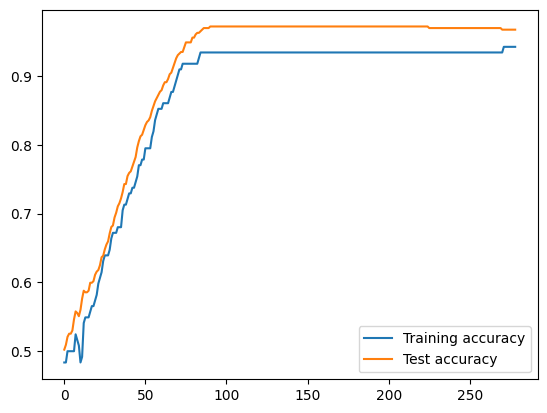

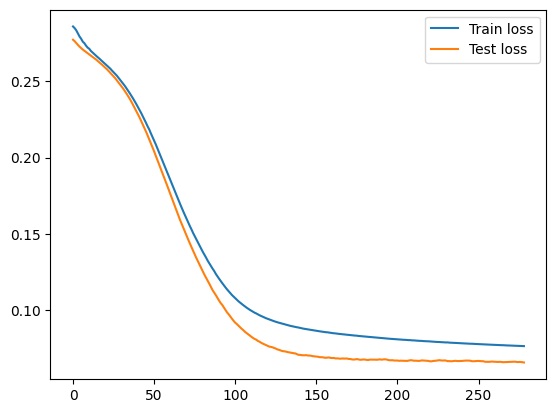

14/14 [==============================] - 0s 2ms/step - loss: 0.0659 - accuracy: 0.9676
[0.06592229753732681, 0.9675925970077515]


In [71]:
model = grid_search(params, x_train, y_train, k_fold_val, x_test, y_test)
test_model(model, x_test, y_test)

# ML Cup

In [104]:
x_train, y_train, x_test, _ = load_dataset("cup", True)
print(x_train.shape, y_train.shape)
print(x_test.shape)

(1492, 9) (1492, 2)
(529, 9)


In [105]:
params = {
    "task": "regression",
    "trials_train": 5,
    "trials_test": 10,
    "initialization": {
        "type": "uniform",
        "min": -0.5,
        "max": 0.5
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.001
    },
    "max_epochs": [500],
    "learning_rate": [0.01],
    "batch_size": [None],
    "nesterov": False,
    "momentum": [0.9],
    "learning_rate_decay": None,
    "regularization": [
        {
            "type": "l1",
            "value": [0.01]
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [10],
        },
    ]
}


k_fold_val = {
    "type": "k-fold",
    "n_folds": 5
}

hold_out_val = {
    "type": "hold-out",
    "val_split": 0.15
}

Testing configuration 1/1:
{'batch_size': None, 'learning_rate': 0.01, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.001}, 'task': 'regression', 'trials_train': 5, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 10}

Executing fold 1/5


100%|█████████████████████████████████████████████| 5/5 [00:30<00:00,  6.11s/it]


Fold 1/5 median val_loss: 0.19434672594070435, std val_loss 0.001844272355411295
Fold 1/5 median train_loss: 0.193853959441185, std train_loss 0.003111411845677442
Fold 1/5 median val_mee: 0.3735908567905426, std val_mee 0.004647112056142493
Fold 1/5 median train_mee: 0.3681683838367462, train_mee 0.006958321013537082

Executing fold 2/5


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.40s/it]


Fold 2/5 median val_loss: 0.19004246592521667, std val_loss 0.004879179799899302
Fold 2/5 median train_loss: 0.19238080084323883, std train_loss 0.00357590880297389
Fold 2/5 median val_mee: 0.35483768582344055, std val_mee 0.004130871366912167
Fold 2/5 median train_mee: 0.35207054018974304, train_mee 0.005714244405791029

Executing fold 3/5


100%|█████████████████████████████████████████████| 5/5 [00:42<00:00,  8.53s/it]


Fold 3/5 median val_loss: 0.18107034265995026, std val_loss 0.00305427299774901
Fold 3/5 median train_loss: 0.19733873009681702, std train_loss 0.0024014568184078963
Fold 3/5 median val_mee: 0.34324294328689575, std val_mee 0.006420117236057966
Fold 3/5 median train_mee: 0.36544057726860046, train_mee 0.003962940692659317

Executing fold 4/5


100%|█████████████████████████████████████████████| 5/5 [00:42<00:00,  8.44s/it]


Fold 4/5 median val_loss: 0.21699078381061554, std val_loss 0.004177580235037803
Fold 4/5 median train_loss: 0.18586039543151855, std train_loss 0.0025068275276275516
Fold 4/5 median val_mee: 0.3733465075492859, std val_mee 0.005867094116923108
Fold 4/5 median train_mee: 0.3496476411819458, train_mee 0.005908059656112245

Executing fold 5/5


100%|█████████████████████████████████████████████| 5/5 [00:34<00:00,  6.88s/it]


Fold 5/5 median val_loss: 0.1850070208311081, std val_loss 0.0028434132219900595
Fold 5/5 median train_loss: 0.19480031728744507, std train_loss 0.002574761768799052
Fold 5/5 median val_mee: 0.35035794973373413, std val_mee 0.006678268269380463
Fold 5/5 median train_mee: 0.37015247344970703, train_mee 0.004009246253350852

Mean val_loss: 0.19349146783351898, std val_loss: 0.012578673407788173
Mean train_loss: 0.1928468406200409, std train_loss: 0.003847987524079462
Mean val_mee: 0.3590751886367798, std val_mee: 0.012320566890020715
Mean train_mee: 0.3590751886367798, std train_mee: 0.008525696693013864






Best configuration (loss 0.19349146783351898):
{'batch_size': None, 'learning_rate': 0.01, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.001}, 'task': 'regression', 'trials_train': 5, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regulariz

 10%|████▍                                       | 1/10 [00:04<00:37,  4.12s/it]

Trial 1/10 train_loss: 0.1943889558315277
Trial 1/10 train_mee: 0.3584446609020233


 20%|████████▊                                   | 2/10 [00:11<00:49,  6.25s/it]

Trial 2/10 train_loss: 0.18419745564460754
Trial 2/10 train_mee: 0.36471617221832275


 30%|█████████████▏                              | 3/10 [00:15<00:36,  5.17s/it]

Trial 3/10 train_loss: 0.19425082206726074
Trial 3/10 train_mee: 0.3598128855228424


 40%|█████████████████▌                          | 4/10 [00:19<00:26,  4.47s/it]

Trial 4/10 train_loss: 0.19475440680980682
Trial 4/10 train_mee: 0.36823686957359314


 50%|██████████████████████                      | 5/10 [00:22<00:19,  3.91s/it]

Trial 5/10 train_loss: 0.19389063119888306
Trial 5/10 train_mee: 0.3712218701839447


 60%|██████████████████████████▍                 | 6/10 [00:24<00:14,  3.54s/it]

Trial 6/10 train_loss: 0.19357827305793762
Trial 6/10 train_mee: 0.3571604788303375


 70%|██████████████████████████████▊             | 7/10 [00:27<00:09,  3.31s/it]

Trial 7/10 train_loss: 0.19133079051971436
Trial 7/10 train_mee: 0.3608850836753845


 80%|███████████████████████████████████▏        | 8/10 [00:31<00:06,  3.39s/it]

Trial 8/10 train_loss: 0.1922704577445984
Trial 8/10 train_mee: 0.35800987482070923


 90%|███████████████████████████████████████▌    | 9/10 [00:37<00:04,  4.24s/it]

Trial 9/10 train_loss: 0.19419308006763458
Trial 9/10 train_mee: 0.35831573605537415


100%|███████████████████████████████████████████| 10/10 [00:41<00:00,  4.12s/it]

Trial 10/10 train_loss: 0.18507260084152222
Trial 10/10 train_mee: 0.3649287521839142

Median train_loss: 0.19389063119888306, std train_loss 0.0037174602744760865
Median train_mee: 0.3712218701839447, std train_mee 0.004595424968178355


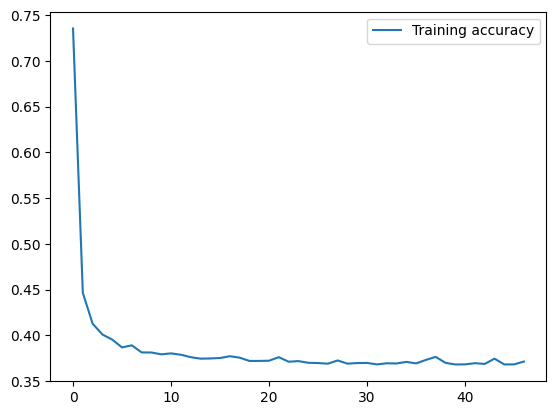

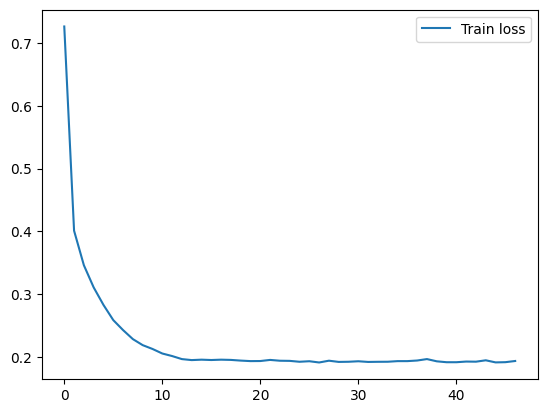

In [106]:
model = grid_search(params, x_train, y_train, k_fold_val)
# model.summary()
# test_model(model, x_test, y_test)

(1492, 2)
47/47 [==============================] - 0s 1ms/step


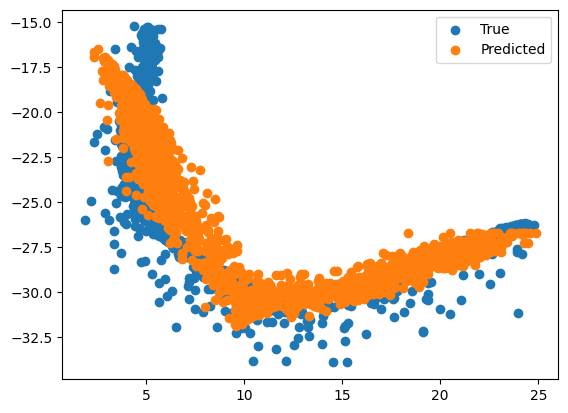

In [107]:
y_train_rescaled = scaler.inverse_transform(y_train)
print(y_train.shape)

plt.scatter(y_train_rescaled[:, 0], y_train_rescaled[:, 1], label="True")
pred = model.predict(x_train)
pred = scaler.inverse_transform(pred)
plt.scatter(pred[:, 0], pred[:, 1], label = "Predicted")
plt.legend()
plt.show()